# How to Compute Variance?

Xuefeng Xu  
2025-10-03

Given a dataset $\{x_1, \ldots, x_n\}$, variance measures how much data
points deviate from their mean. While the mathematical definition is
straightforward, the way we implement variance can have a big impact on
numerical stability.

## 1 Textbook Formulas

The most common definition computes the mean first, then the average
squared deviation from it:

<span id="eq-textbook-var-twopass">$$
\mu = \frac{1}{n} \sum_{i=1}^n x_i,\ \sigma^2 = \frac{1}{n} \sum_{i=1}^n (x_i - \mu)^2.
 \qquad(1)$$</span>

In [1]:
def var_twopass_textbook(x):
    n, s = 0, 0
    for xi in x:
        n += 1
        s += xi

    mu = s / n
    sd = 0
    for xi in x:
        sd += (xi - mu) ** 2
    return sd / n

This requires two passes over the data. For
[streaming](https://en.wikipedia.org/wiki/Streaming_data) or
memory-constrained scenarios, a one-pass formula is often considered:

<span id="eq-textbook-var-onepass">$$
\sigma^2 = \frac{1}{n} \sum_{i=1}^n x_i^2 - \left(\frac{1}{n} \sum_{i=1}^n x_i\right)^2.
 \qquad(2)$$</span>

In [2]:
def var_onepass_textbook(x):
    n, s, sq = 0, 0, 0
    for xi in x:
        n += 1
        s += xi
        sq += xi ** 2
    return sq / n - (s / n) ** 2

In exact arithmetic, these two formulas are identical. But in
floating-point arithmetic, they can yield very different results.

## 2 Numerical Cancellation

Let’s test both formulas on a simple dataset:

In [3]:
import numpy as np

x = np.array([0., 1., 2.])
print("Two-pass (Textbook):", var_twopass_textbook(x))
print("One-pass (Textbook):", var_onepass_textbook(x))

Two-pass (Textbook): 0.6666666666666666
One-pass (Textbook): 0.6666666666666667

So far, so good. But if we shift all values by a large constant, the
one-pass version quickly breaks down due to cancellation errors:

In [4]:
for shift in [1e3, 1e6, 1e9, 1e12]:
    xt = x + shift
    print(f"Shift: {shift:.0e}")
    print(f"Two-pass (Textbook): {var_twopass_textbook(xt)}")
    print(f"One-pass (Textbook): {var_onepass_textbook(xt)}\n")

Shift: 1e+03
Two-pass (Textbook): 0.6666666666666666
One-pass (Textbook): 0.6666666666278616

Shift: 1e+06
Two-pass (Textbook): 0.6666666666666666
One-pass (Textbook): 0.6666259765625

Shift: 1e+09
Two-pass (Textbook): 0.6666666666666666
One-pass (Textbook): 0.0

Shift: 1e+12
Two-pass (Textbook): 0.6666666666666666
One-pass (Textbook): -134217728.0


In [5]:
import matplotlib.pyplot as plt

def plot_errors(x, var_func, error_type="absolute"):
    ref = np.var(x)
    shifts = [10**i for i in range(0, 20)]

    errors = []
    for shift in shifts:
        xt = x + shift
        var = var_func(xt)

        if error_type == "absolute":
            errors.append(abs(var - ref))
        elif error_type == "relative":
            errors.append(abs(var - ref) / abs(ref))

    fig, ax = plt.subplots(figsize=(3, 3))
    ax.loglog(shifts, errors, "*-r")
    ax.set_xlabel("Shift value")
    ax.set_ylabel(f"{error_type.capitalize()} error")
    ax.set_title(f"{var_func.__name__}")
    ax.grid()

``` python
plot_errors(x, var_onepass_textbook, error_type="absolute")
plot_errors(x, var_onepass_textbook, error_type="relative")
```

<table>
<colgroup>
<col style="width: 50%" />
<col style="width: 50%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: left;"><div id="cell-fig-abs-error" class="cell"
data-execution_count="6" width="50.0%" data-layout-align="left">
<div class="cell-output cell-output-display">
<figure id="fig-abs-error">
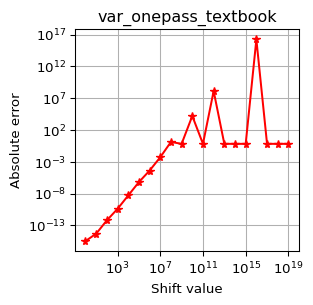
<figcaption>(a) Absolute error</figcaption>
</figure>
</div>
</div></td>
<td style="text-align: left;"><div class="preview-image" width="50.0%"
data-layout-align="left">
<div id="cell-fig-rel-error" class="cell" data-execution_count="7">
<div class="cell-output cell-output-display">
<figure id="fig-rel-error">
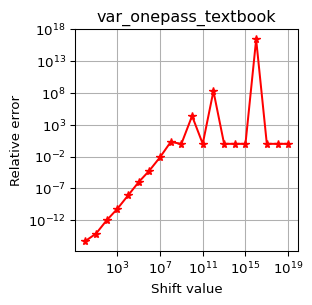
<figcaption>(b) Relative error</figcaption>
</figure>
</div>
</div>
</div></td>
</tr>
</tbody>
</table>

Figure 1: Error plots for the one-pass textbook formula.

This instability makes the textbook one-pass formula unsuitable for
real-world use.

## 3 Floating Point Arithmetic

Why does this happen? Because floating-point numbers can only represent
a finite number of digits. Squaring a large number, for example, can
lose precision:

In [8]:
1000000001.0 ** 2
# 1.000000002000000001e+18

1.000000002e+18

Moreover, floating point numbers cannot exactly represent all values,
especially very large numbers, leading to rounding errors.

In [9]:
1000000002000000001.0

1.000000002e+18

Most systems use the [IEEE 754
standard](https://en.wikipedia.org/wiki/IEEE_754). In double precision
(64-bit), numbers have 53 bits of precision, so integers larger than
$2^{53}-1$ (9007199254740991) cannot be represented exactly. For
example, adding small increments beyond this threshold reveals precision
loss:

In [10]:
print(9007199254740991.0)        # correct
print(9007199254740991.0 + 1.0)  # still correct
print(9007199254740991.0 + 2.0)  # wrong

9007199254740991.0
9007199254740992.0
9007199254740992.0

The hex representation makes this clear:

In [11]:
print(hex(9007199254740991))  # exact
print(hex(9007199254740992))  # exact
print(hex(9007199254740993))  # last bit lost

0x1fffffffffffff
0x20000000000000
0x20000000000001

Large numbers like:

In [12]:
print(hex(1000000002000000001))

0xde0b6b41e999401

also show lost lower bits, which is exactly what causes variance
miscalculations.

## 4 Stable Alternatives

A better one-pass approach is Welford’s algorithm (Welford 1962).
Instead of subtracting large similar terms, it incrementally updates the
mean $\mu_k=\sum_{i=1}^k x_i / k$ and the squared deviations
$S_k=\sum_{i=1}^k (x_i - \mu_k)^2$ to maintain numerical stability:

<span id="eq-welford">$$
\begin{align*}
\delta_k &= x_k - \mu_{k-1},\\
\mu_k &= \mu_{k-1} + \delta_k / k,\\
S_k &= S_{k-1} + \delta_k (x_k - \mu_k).
\end{align*}
 \qquad(3)$$</span>

In [13]:
def var_onepass_welford(x):
    n, mu, sd = 0, 0, 0
    for xi in x:
        n += 1
        delta = xi - mu
        mu += delta / n
        sd += delta * (xi - mu)
    return sd / n

Testing again with shifts:

In [14]:
for shift in [1e3, 1e6, 1e9, 1e12]:
    xt = x + shift
    print(f"Shift: {shift:.0e}")
    print(f"One-pass (Welford): {var_onepass_welford(xt)}\n")

Shift: 1e+03
One-pass (Welford): 0.6666666666666666

Shift: 1e+06
One-pass (Welford): 0.6666666666666666

Shift: 1e+09
One-pass (Welford): 0.6666666666666666

Shift: 1e+12
One-pass (Welford): 0.6666666666666666


Welford’s method remains stable even under extreme shifts. Other
methods, such as Chan’s algorithm (T. F. Chan, Golub, and LeVeque 1982),
are also numerically stable. Classic studies (Ling 1974; Tony F. Chan,
Golub, and Leveque 1983) provide detailed comparisons.

Chan, T. F., G. H. Golub, and R. J. LeVeque. 1982. “Updating Formulae
and a Pairwise Algorithm for Computing Sample Variances.” In *COMPSTAT
1982 5th Symposium Held at Toulouse 1982*, 30–41. Heidelberg:
Physica-Verlag HD. <https://doi.org/10.1007/978-3-642-51461-6_3>.

Chan, Tony F., Gene H. Golub, and Randall J. Leveque. 1983. “Algorithms
for Computing the Sample Variance: Analysis and Recommendations.” *The
American Statistician* 37 (3): 242–47.
<https://doi.org/10.1080/00031305.1983.10483115>.

Ling, Robert F. 1974. “Comparison of Several Algorithms for Computing
Sample Means and Variances.” *Journal of the American Statistical
Association* 69 (348): 859–66.
<https://doi.org/10.1080/01621459.1974.10480219>.

Welford, B. P. 1962. “Note on a Method for Calculating Corrected Sums of
Squares and Products.” *Technometrics* 4 (3): 419–20.
<https://doi.org/10.1080/00401706.1962.10490022>.